
# CATTLE BREED CLASSIFIER



Upload File

In [6]:
from google.colab import files
uploaded = files.upload()


Saving archive.zip to archive.zip


Unzip the file

In [9]:
import zipfile
import os

# Create dataset folder
os.makedirs("/content/dataset", exist_ok=True)

# Unzip
with zipfile.ZipFile("archive.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset")

# Check folders
os.listdir("/content/dataset")



['Cattle Breeds']

Prepare the Image Data Generator

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 20% data for validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    "/content/dataset/Cattle_Breeds",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    "/content/dataset/Cattle_Breeds",
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 969 images belonging to 5 classes.
Found 239 images belonging to 5 classes.


Building Model : Transfer Learing

In [21]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Load pre-trained MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base layers

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training Model

In [22]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.4322 - loss: 1.4311 - val_accuracy: 0.6527 - val_loss: 0.9847
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7341 - loss: 0.7217 - val_accuracy: 0.6653 - val_loss: 0.9579
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8179 - loss: 0.5277 - val_accuracy: 0.6444 - val_loss: 1.0015
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8422 - loss: 0.4693 - val_accuracy: 0.6820 - val_loss: 0.9307
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8849 - loss: 0.3522 - val_accuracy: 0.7071 - val_loss: 0.8960
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8947 - loss: 0.3145 - val_accuracy: 0.7155 - val_loss: 0.9234
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9263 - loss: 0.2473 - val_accuracy: 0.7197 - val_loss: 0.9046
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9407 - loss: 0.1963 - val_accuracy: 0.7322 - val_loss:

Evaluate Model

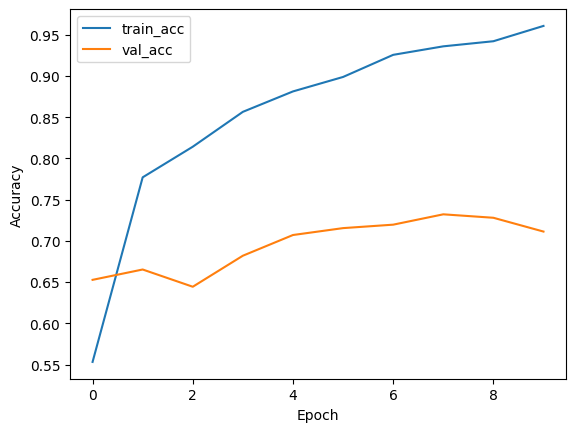

In [23]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Predict on new Image

In [24]:
print(train_generator.class_indices)


{'Ayrshire cattle': 0, 'Brown Swiss cattle': 1, 'Holstein Friesian cattle': 2, 'Jersey cattle': 3, 'Red Dane cattle': 4}


In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np

img_path = "/content/SG0105880-scaled.jpg"  # replace with your test image path
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)/255.0
img_array = np.expand_dims(img_array, axis=0)

pred = model.predict(img_array)
pred_class = train_generator.class_indices
predicted_breed = list(pred_class.keys())[np.argmax(pred)]
print("Predicted Breed:", predicted_breed)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Predicted Breed: Brown Swiss cattle
